# <center> Time series analysis to forecast passengers Traffic Movement in murtala Mohammed Airport in Nigeria</center>

<img src="air.jpg" />

import pandas as pd
import numpy as np
from scipy.stats import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('passengers.csv',)
rang = pd.date_range('2012', '2017',  freq='M')
data.set_index(rang, inplace = True)
data = data.drop(['Date'], axis = 1)
data.head(3)

,passengers
2012-01-31,279748
2012-02-29,350630
2012-03-31,372514


### Descriptive Statistics

In [3]:
data.describe()

,passengers
count,60.000000
mean,331770.333333
std,33719.946173
min,267465.000000
25%,301866.000000
50%,332844.000000
75%,355969.750000
max,434782.000000


### Data Visualization

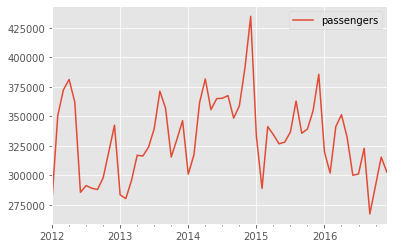

In [4]:
plt.style.use('ggplot')
data.plot()

Inspectiong the series above we can see an obvious stochatic trend over time and also presence of seasonality. Hence the series have to be made stationary for further analysis

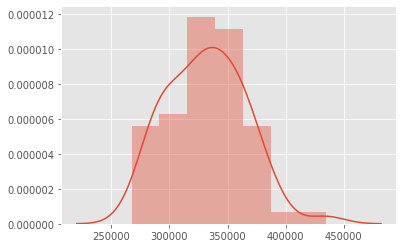

In [5]:
sns.distplot(data,kde = True);

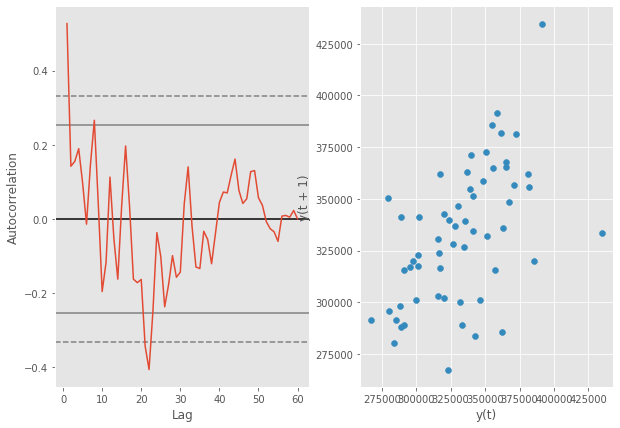

In [6]:
from pandas.plotting import lag_plot, autocorrelation_plot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 7))
autocorrelation_plot(data['passengers'], ax = ax1)
lag_plot(data['passengers']);

In [7]:
data['passengers'].corr(data['passengers'].shift(1))

0.5408552535911614

From the above inspection of the given series we can see that the series is auto correlated with it's lag, apparently showing that our series is not a random walk and can be modelled

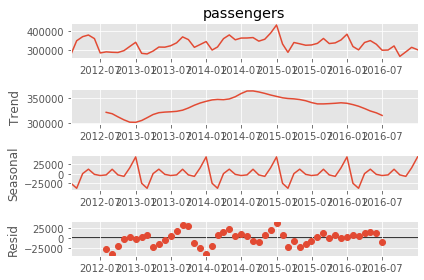

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(data['passengers'], model='additive')
x = decomposed.plot() #See note below about this

### Test for stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

result = adfuller(data['passengers'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.624828
p-value: 0.087974
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595


In [10]:
result = kpss(data['passengers'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.138201
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


from the above result, the series is not stationary since we have the p-value (0.08) to be greater than our apha values (1%, 5%, and 10%)

### Making Series Stationary

    - Estimating and eliminating Trend
      * Aggregation
      * Smooting (Moving Average, Exponential weighted avearge)
      * Polynomial fit
      
    - Eliminating Trend and seasonality 
      * Differencing
      * Decomposing

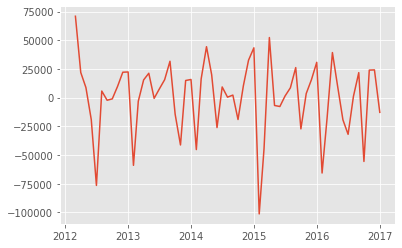

In [11]:
shift = data['passengers'].shift(1)
dtrend = data['passengers'] - shift

# or
diff = data['passengers'].diff()
plt.plot(diff)
#plt.plot(dtrend)

In [12]:
result = adfuller(diff.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.029003
p-value: 0.000000
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595


In [13]:
result = kpss(diff.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.248484
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


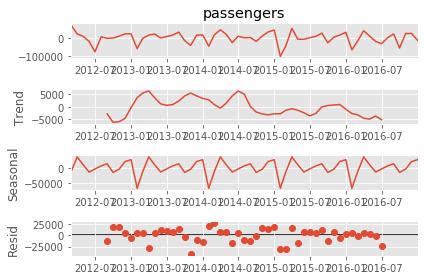

In [14]:
decomposed1 = seasonal_decompose(diff.dropna(), model='additive')
x = decomposed1.plot() 

Differencing the series once made it stationary, hence we can proceed to build an ARIMA Model

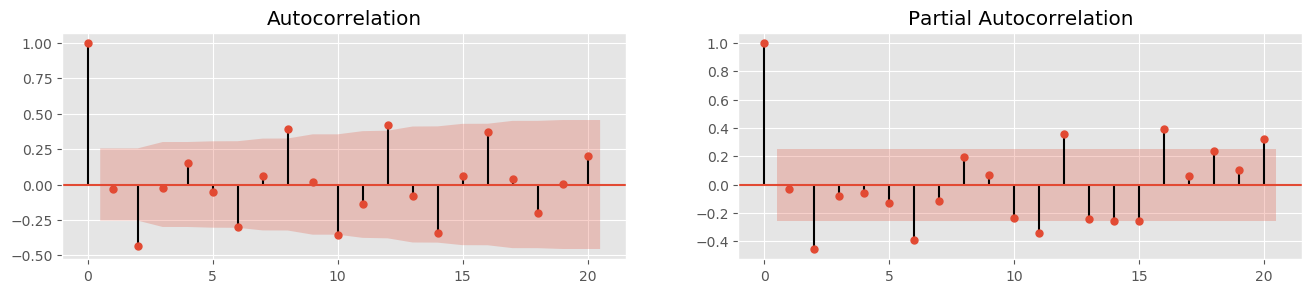

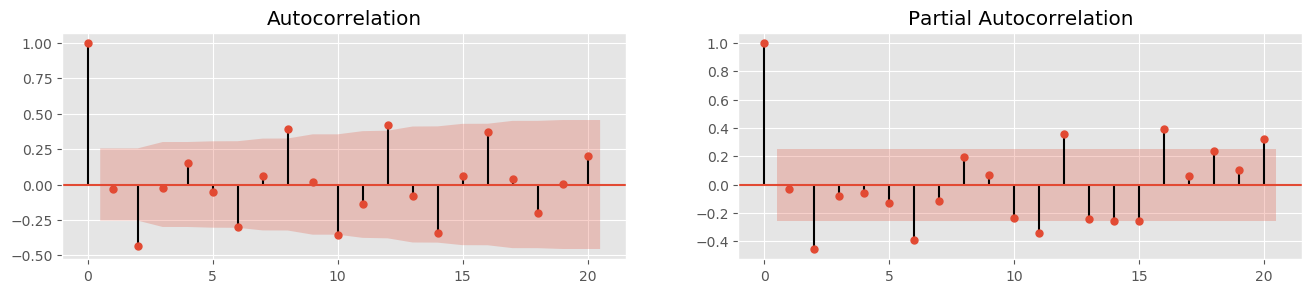

In [15]:
from statsmodels.tsa.stattools import acf , pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(diff.dropna(),lags = 20, ax = axes[0])
plot_pacf(diff.dropna(),lags = 20, ax = axes[1])

### AR Model

In [16]:
from statsmodels.tsa.ar_model import AR 
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

In [17]:
data['diff'] = data['passengers'].diff()
X = data['diff'].dropna()
train = X[0:len(X)-12]
test = X[X[len(X)-12:]]

""""data['passengers'] = data['passengers'].diff()
train = data[0:len(data) -12]
test = data[len(data)-12:]"""""

print(train.shape, test.shape)

(47,) (12,)


In [18]:
model = AR(train.dropna())
model_fit = model.fit()
print("Lag: %s" % model_fit.k_ar)
print("Coefficients: %s" % model_fit.params)

Lag: 10
Coefficients: const       3706.515814
L1.diff       -0.254738
L2.diff       -0.515740
L3.diff       -0.219542
L4.diff       -0.174361
L5.diff       -0.202097
L6.diff       -0.215941
L7.diff       -0.046194
L8.diff        0.131466
L9.diff        0.148593
L10.diff      -0.134225
dtype: float64


In [19]:
"""""mod = ARMA(train, order = (10,0))
mod_fit = mod.fit()
mod_fit.params"""""

'""mod = ARMA(train, order = (10,0))\nmod_fit = mod.fit()\nmod_fit.params'

In [20]:
# make predictions 
predictions = model_fit.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False)

# create a comparison dataframe
compare_df = pd.concat([data['diff'].tail(12),predictions], axis=1).rename(columns={'diff': 'actual', 0:'predicted'})

In [21]:
compare_df

,actual,predicted
2016-01-31,-65639.0,-24432.527986
2016-02-29,-17899.0,-10556.816881
2016-03-31,39262.0,15852.041482
2016-04-30,10146.0,6984.049631
2016-05-31,-19314.0,-10244.327827
2016-06-30,-31941.0,-8431.068218
2016-07-31,1047.0,19052.729392
2016-08-31,21773.0,10309.346389
2016-09-30,-55574.0,-10181.737164
2016-10-31,23976.0,-11046.503262


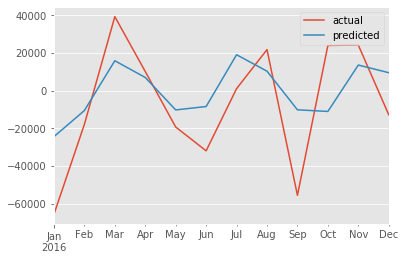

In [22]:
compare_df.plot()

In [23]:
from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt(mean_squared_error(data['diff'].tail(12), predictions))
rmse

24661.1640457126

### ARIMA

In [24]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train.dropna(), order = (7,0,2))
model_result = model.fit(disp =0)
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   diff   No. Observations:                   47
Model:                     ARMA(7, 2)   Log Likelihood                -555.474
Method:                       css-mle   S.D. of innovations          23879.956
Date:                Fri, 27 Nov 2020   AIC                           1132.948
Time:                        09:00:49   BIC                           1153.300
Sample:                    02-29-2012   HQIC                          1140.606
                         - 12-31-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2216        nan        nan        nan         nan         nan
ar.L1.diff    -0.5714        nan        nan        nan         nan         nan
ar.L2.diff    -0.9523        nan        nan        nan         nan         nan
ar.L3.diff    -0.3920   3.46e-06  -1.13e+05      0.000      -0.392      -0.392
ar.L4.diff    -0.1217        nan        nan        nan         nan         nan
ar.L5.diff    -0.2841        nan        nan        nan         nan         nan
ar.L6.diff    -0.2286        nan        nan        nan         nan         nan
ar.L7.diff    -0.3887        nan        nan        nan         nan         nan
ma.L1.diff     0.3723      0.085      4.388      0.000       0.206       0.539
ma.L2.diff     1.0000      0.098     10.236      0.000       0.809       1.191
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9687           -0.7808j            1.2442           -0.1080
AR.2            0.9687           +0.7808j            1.2442            0.1080
AR.3           -0.0291           -0.9996j            1.0000           -0.2546
AR.4           -0.0291           +0.9996j            1.0000            0.2546
AR.5           -1.1755           -0.0000j            1.1755           -0.5000
AR.6           -0.6459           -0.9982j            1.1889           -0.3414
AR.7           -0.6459           +0.9982j            1.1889            0.3414
MA.1           -0.1861           -0.9825j            1.0000           -0.2798
MA.2           -0.1861           +0.9825j            1.0000            0.2798
-----------------------------------------------------------------------------
"""

In [25]:
# make predictions 
predictions = model_result.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False)

# create a comparison dataframe
compare_df = pd.concat([data['diff'].tail(12),predictions], axis=1).rename(columns={'diff': 'actual', 0:'predicted'})
compare_df.head()

,actual,predicted
2016-01-31,-65639.0,-51178.484516
2016-02-29,-17899.0,11653.913370
2016-03-31,39262.0,23565.096085
2016-04-30,10146.0,-2500.568021
2016-05-31,-19314.0,-32637.061068


In [26]:
from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt(mean_squared_error(data['diff'].tail(12), predictions))
rmse

21255.481579830983

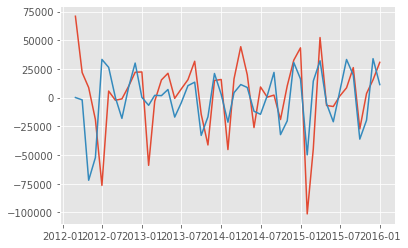

In [27]:
plt.plot(train)
plt.plot(model_result.fittedvalues)

### Model Predictions

In [28]:
arima_pred = pd.Series(model_result.fittedvalues, copy=True)
print(arima_pred.head())

2012-02-29      100.221642
2012-03-31    -1960.668258
2012-04-30   -71947.974682
2012-05-31   -52156.920088
2012-06-30    33294.343415
Freq: M, dtype: float64


In [29]:
arima_pred_cumsum = arima_pred.cumsum()
#data['diff'] = data['diff'].cumsum()
print (arima_pred_cumsum.head())

2012-02-29       100.221642
2012-03-31     -1860.446616
2012-04-30    -73808.421298
2012-05-31   -125965.341386
2012-06-30    -92670.997971
Freq: M, dtype: float64


In [30]:
pred_data = pd.Series(train.iloc[0], index=train.index)
pred_data = pred_data.add(arima_pred_cumsum,fill_value=0)
pred_data.head(3)

2012-02-29    70982.221642
2012-03-31    69021.553384
2012-04-30    -2926.421298
Freq: M, dtype: float64

In [31]:
#new_con = data['diff'].expanding(min_periods=0).sum() + data['passengers']

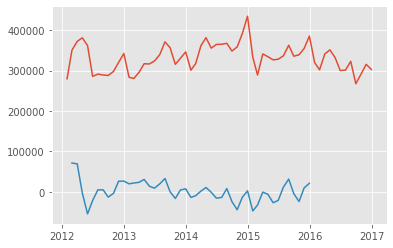

In [32]:
plt.plot(data.passengers)
plt.plot(pred_data)

### ARIMA Grid Search

In [33]:
def evaluation(train, test,  p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train, order = (p,d,q))
                    model_result = model.fit(disp = 0)
                    predictions = model_result.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False)
                    rmse = np.sqrt(mean_squared_error(data['diff'].tail(12), predictions))
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' %(order, rmse))
                except:
                    continue
    print("Best ARIMA%s RMSE=%.3f" % (best_cfg, best_score))

In [34]:
p_values = range(0,13)
d_values = range(0, 2)
q_values = range(0, 8)
evaluation(train, test, p_values, d_values, q_values )

ARIMA(0, 0, 0) RMSE=32897.475
ARIMA(0, 0, 1) RMSE=33609.350
ARIMA(0, 0, 2) RMSE=31116.749
ARIMA(0, 0, 4) RMSE=31678.513
ARIMA(0, 0, 6) RMSE=31775.106
ARIMA(0, 1, 0) RMSE=32168.504
ARIMA(0, 1, 1) RMSE=28193.755
ARIMA(0, 1, 2) RMSE=28586.782
ARIMA(0, 1, 3) RMSE=24953.028
ARIMA(0, 1, 4) RMSE=25770.065
ARIMA(0, 1, 5) RMSE=25748.621
ARIMA(0, 1, 6) RMSE=25755.112
ARIMA(0, 1, 7) RMSE=30917.434
ARIMA(1, 0, 0) RMSE=33029.440
ARIMA(1, 0, 1) RMSE=30789.523
ARIMA(1, 0, 2) RMSE=31767.618
ARIMA(1, 0, 3) RMSE=31207.885
ARIMA(1, 0, 4) RMSE=30193.709
ARIMA(1, 1, 0) RMSE=31644.877
ARIMA(2, 0, 0) RMSE=30638.406
ARIMA(2, 0, 1) RMSE=32351.380
ARIMA(2, 0, 2) RMSE=31861.916
ARIMA(2, 0, 3) RMSE=30132.987
ARIMA(2, 1, 0) RMSE=29556.661
ARIMA(2, 1, 1) RMSE=25078.281
ARIMA(2, 1, 2) RMSE=26477.858
ARIMA(2, 1, 3) RMSE=25455.434
ARIMA(3, 0, 0) RMSE=30598.185
ARIMA(3, 0, 1) RMSE=31301.529
ARIMA(3, 1, 0) RMSE=26594.504
ARIMA(3, 1, 1) RMSE=24872.844
ARIMA(3, 1, 2) RMSE=24938.776
ARIMA(4, 0, 0) RMSE=31622.261
ARIMA(4, 0

### <center> Machine Learning Approach</center>

### Feature Enginering on the series

- creating Date time Features

In [3]:
data['month'] = [data.index[i].month for i in range(len(data))]
data['day'] = [data.index[i].day for i in range(len(data))]

- lag features

In [4]:
data['lag1'] = data['passengers'].shift(1)

In [5]:
data.head()

,passengers,month,day,lag1
2012-01-31,279748,1,31,NaN
2012-02-29,350630,2,29,279748.0
2012-03-31,372514,3,31,350630.0
2012-04-30,381269,4,30,372514.0
2012-05-31,362150,5,31,381269.0


- rolling windows statistics [ we can also use lag1.expanding( ) ]
- min
- max
- mean

In [6]:
lag1_roll = data.lag1.rolling(window = 2)
#lag1_roll = data['passengers'].expanding()


lag1_mean = lag1_roll.mean()
lag1_max = lag1_roll.max()
lag1_min = lag1_roll.min()

data = pd.concat([data, lag1_mean, lag1_max, lag1_min ], axis = 1)
data.columns = ['passengers','month', 'day', 'lag1','lag1_mean','lag1_max','lag1_min',]
data.head(3)

,passengers,month,day,lag1,lag1_mean,lag1_max,lag1_min
2012-01-31,279748,1,31,NaN,NaN,NaN,NaN
2012-02-29,350630,2,29,279748.0,NaN,NaN,NaN
2012-03-31,372514,3,31,350630.0,315189.0,350630.0,279748.0


In [7]:
data.fillna(0, inplace = True)

### Create train and test set

In [8]:
train = data.iloc[0:48, :]
test = data.iloc[48:, :]
print(train.shape, test.shape)
train.head()

(48, 7) (12, 7)


,passengers,month,day,lag1,lag1_mean,lag1_max,lag1_min
2012-01-31,279748,1,31,0.0,0.0,0.0,0.0
2012-02-29,350630,2,29,279748.0,0.0,0.0,0.0
2012-03-31,372514,3,31,350630.0,315189.0,350630.0,279748.0
2012-04-30,381269,4,30,372514.0,361572.0,372514.0,350630.0
2012-05-31,362150,5,31,381269.0,376891.5,381269.0,372514.0


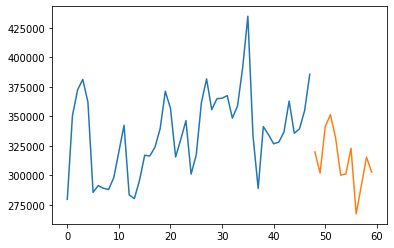

In [19]:
plt.plot(train.passengers.values)
plt.plot([None for i in train.passengers.values] + [i for i in test.passengers.values])

### Persistence Model

In [20]:
x_train, y_train = train.lag1, train.passengers
x_test, y_test = test.lag1, test.passengers

print(x_train.shape, x_test.shape)

(48,) (12,)


In [21]:
# persistence model
def model_persistence(x):
    return x

In [22]:
# walk-forward validation
from sklearn.metrics import mean_squared_error

predictions = list()
for x in x_test:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 32343.304


### modelling

In [23]:
x_train, y_train = train.drop(['passengers'], axis = 1), train.passengers
x_test, y_test = test.drop(['passengers'], axis = 1), test.passengers

In [24]:
print(x_train.shape, x_test.shape)

(48, 6) (12, 6)


In [25]:
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, FeaturesData, Pool
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from math import sqrt

In [26]:
#Gradient boost regressor 

params = {"n_estimators": 5, "max_depth" : 7,  "learning_rate": 0.001, "random_state":9000}
model0 = GradientBoostingRegressor(**params)

# Fit model

model0.fit(x_train,y_train)

# Get predictions

predict = model0.predict(x_test)

# Evaluation

rms = sqrt(mean_squared_error(y_test, predict))
print(rms)

32720.586697397834


In [27]:
#XGBoost
# Create the model
model2 = xgb.XGBRegressor(learning_rate=0.06,max_depth=6,n_estimators=5000,subsample=0.69898,random_state=42)

# Fit the Model
model2.fit(x_train,y_train,eval_set=[(x_train, y_train), (x_test, y_test)],early_stopping_rounds=100,  verbose=False)

# Predict 
preds = model2.predict(x_test)

# Evaluation 
rms = sqrt(mean_squared_error(y_test, preds))
print(rms)

[09:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
21607.50088997914


In [28]:
# Parameters

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 1000,
    "n_estimators": 1000,
    "random_state": 9000
}

model3 = lgb.LGBMRegressor(**hyper_params)

# Fit and Train the Model

model3.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

# predict

y_pred = model3.predict(x_test, num_iteration=model3.best_iteration_)


[1]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[3]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[4]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[5]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[6]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[7]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[8]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[9]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[10]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[11]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[12]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[13]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[14]	valid_0's l1: 360822	valid_0's l2: 1.30681e+

[244]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[245]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[246]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[247]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[248]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[249]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[250]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[251]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[252]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[253]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[254]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[255]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[256]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[257]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[258]	valid_0's l1: 

[528]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[529]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[530]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[531]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[532]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[533]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[534]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[535]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[536]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[537]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[538]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[539]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[540]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[541]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[542]	valid_0's l1: 

[800]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[801]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[802]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[803]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[804]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[805]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[806]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[807]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[808]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[809]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[810]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[811]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[812]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[813]	valid_0's l1: 360822	valid_0's l2: 1.30681e+11	valid_0's auc: 1
[814]	valid_0's l1: 

In [29]:
predictions = (predict*0.2 + preds*0.7 + y_pred *0.1)
rms = sqrt(mean_squared_error(y_test, predictions))
print(rms)

22774.976857620153


In [30]:
model_pred = pd.DataFrame({'test passengers': test.passengers, "predictions": predictions})
model_pred

,test passengers,predictions
2016-01-31,319965,318546.222913
2016-02-29,302066,314691.976615
2016-03-31,341328,325570.092474
2016-04-30,351474,335423.198357
2016-05-31,332160,342336.967539
2016-06-30,300219,327910.082555
2016-07-31,301266,322243.795692
2016-08-31,323039,319890.152329
2016-09-30,267465,327522.994741
2016-10-31,291441,306869.220658


### Conclusion

The above project was carried to build a forecasting model using Statistical time series analysis approach and a machine learning approach

- Note:

model bult is still up for further improvement, thingsto try include grid searching machine learning model parameters or optimal results